# Interactive pixel classification in napari using scikit learn
Pixel classification is a technique for assigning pixels to multiple classes. If there are two classes (object and background), we are talking about binarization. In this example we use a [random forest classifier](https://en.wikipedia.org/wiki/Random_forest) for pixel classification.

See also
* [Scikit-image random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Classification of land cover by Chris Holden](https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)

As usual, we start by loading an example image.

In [1]:
from skimage.io import imread, imshow
image = imread('https://samples.fiji.sc/blobs.png')

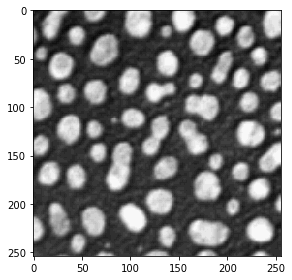

In [2]:
imshow(image)

## Generating a feature stack
Pixel classifiers such as the random forest classifier takes multiple images as input. We typically call these images a feature stack because for every pixel exist now multiple values (features). In the following example we create a feature stack containing three features:
* The original pixel value
* The pixel value after a Gaussian blur
* The pixel value of the Gaussian blurred image processed through a Sobel operator.

Thus, we denoise the image and detect edges. All three images serve the pixel classifier to differentiate positive an negative pixels.

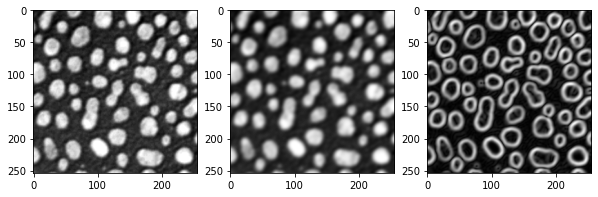

In [3]:
from skimage import filters
import numpy as np

def generate_feature_stack(image):
    # determine features
    blurred = filters.gaussian(image, sigma=2)
    edges = filters.sobel(blurred)

    # collect features in a stack
    # The ravel() function turns a nD image into a 1-D image.
    # We need to use it because scikit-learn expects values in a 1-D format here. 
    feature_stack = [
        image.ravel(),
        blurred.ravel(),
        edges.ravel()
    ]
    
    # return stack as numpy-array
    return np.asarray(feature_stack)

feature_stack = generate_feature_stack(image)

# show feature images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(10,10))

# reshape(image.shape) is the opposite of ravel() here. We just need it for visualization.
axes[0].imshow(feature_stack[0].reshape(image.shape), cmap=plt.cm.gray)
axes[1].imshow(feature_stack[1].reshape(image.shape), cmap=plt.cm.gray)
axes[2].imshow(feature_stack[2].reshape(image.shape), cmap=plt.cm.gray)

## Formating data
We need to format the input data so that it fits to what scikit learn expects. Scikit-learn asks for an array of shape (n, m) as input data and (n) annotations. n corresponds to number of pixels and m to number of features. In our case m = 3.

In [4]:
def format_data(feature_stack, annotation):
    # reformat the data to match what scikit-learn expects
    # transpose the feature stack
    X = feature_stack.T
    # make the annotation 1-dimensional
    y = annotation.ravel()
    
    # remove all pixels from the feature and annotations which have not been annotated
    mask = y > 0
    X = X[mask]
    y = y[mask]

    return X, y

## Interactive segmentation
We can also use napari to annotate some regions as negative (label = 1) and positive (label = 2).

In [11]:
import napari

# start napari
viewer = napari.Viewer()

# add image
viewer.add_image(image)

# add an empty labels layer and keep it in a variable
labels = viewer.add_labels(np.zeros(image.shape).astype(int))

# Manual annotation
The user (that might be YOU!) should annotate two regions inside and outside the objects of interest. First, use `Paint mode` to annotate background. Then, increase the `label` by clicking the `+` button an annotate also some objects of interest.

Your annotation should approximately look like this:

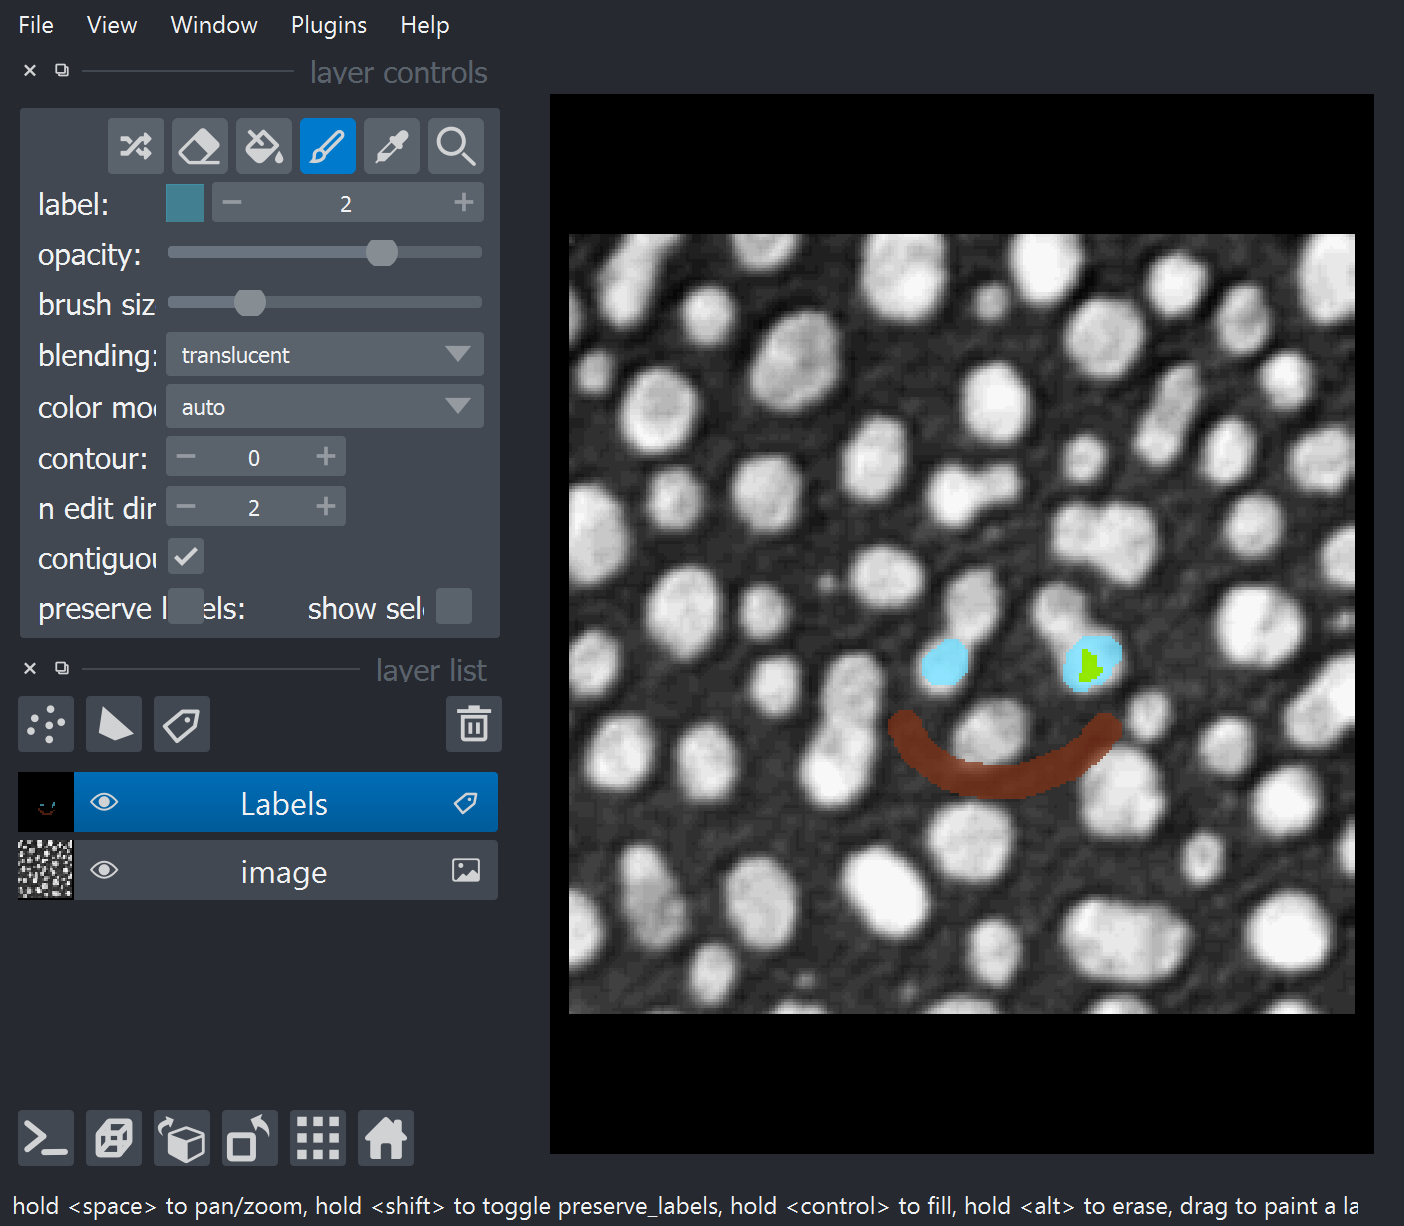

In [12]:
napari.utils.nbscreenshot(viewer)

## Training the random forest classifier
We now train the [random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) by providing the feature stack X and the annotations y. Therefore, we retrieve the annotations from the napari layer:

c:\users\rober\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


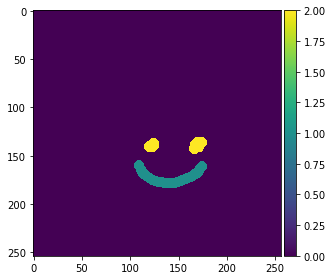

In [13]:
manual_annotations = labels.data

from skimage.io import imshow
imshow(manual_annotations, vmin=0, vmax=2)

In [14]:
# for training, we need to generate features
feature_stack = generate_feature_stack(image)
X, y = format_data(feature_stack, manual_annotations)

# train classifier
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

## Predicting pixel classes
After the classifier has been trained, we can use it to predict pixel classes for whole images. Note in the following code, we provide `feature_stack.T` which are more pixels then X in the commands above, because it also contains the pixels which were not annotated before.

In [17]:
# process the whole image and show result
result_1d = classifier.predict(feature_stack.T) # we subtract 1 to make background = 0
result_2d = result_1d.reshape(image.shape)

Also we add the result to napari.

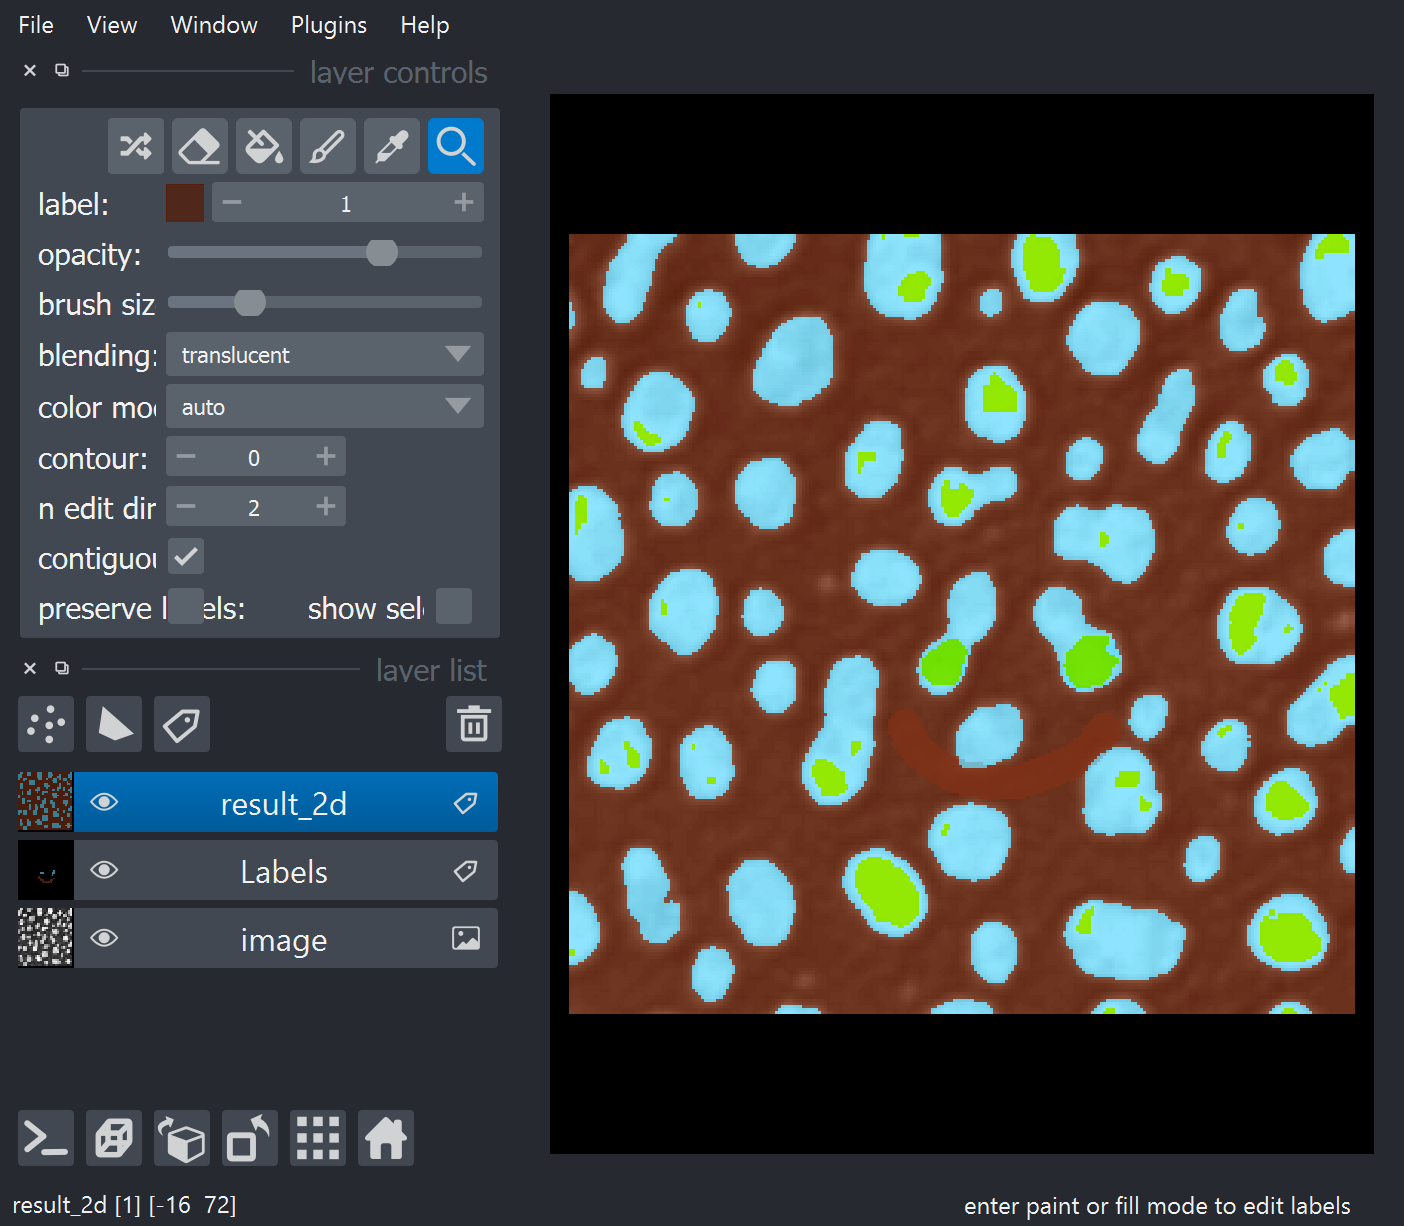

In [20]:
result_layer = viewer.add_labels(result_2d)

napari.utils.nbscreenshot(viewer)

In [21]:
result_layer.visible = False

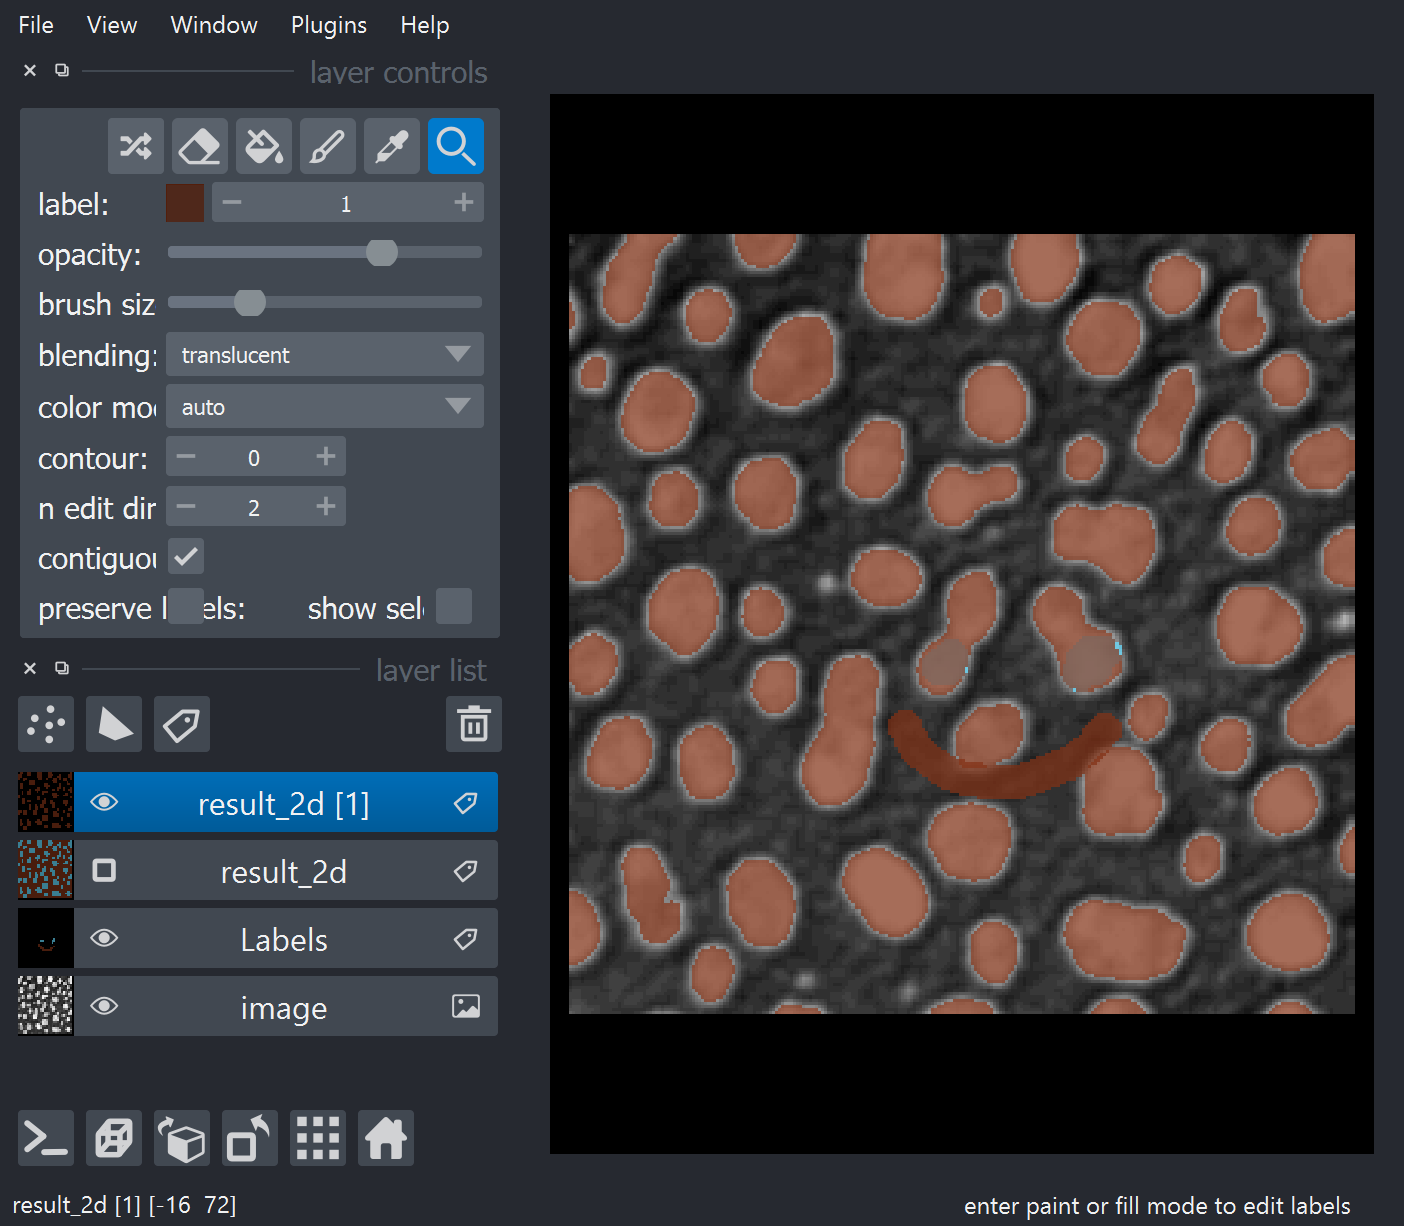

In [22]:
# remove background label
# only works if background was annotated first
result_2d = result_2d - 1

viewer.add_labels(result_2d)

napari.utils.nbscreenshot(viewer)

# Exercise
Change the code so that you can annotate three different regions:
* Blobs
* Background
* The edges between blobs and background